***Fundamentals of Solar Cells and Photovoltaic Systems Engineering***

**Solutions Manual - Chapter 4**

***Problem 4.10***



___Using the same solar cell parameters of Problem S4.8, generate I-V curves and then extract the parameters R $_S$ and R $_P$ from it using the method explained in Section 4.3.3. Determine the minimum value of R $_S$ that produces an error in the extracted Rs above 1%.___

First, we import the Python modules used, define one constant to set the I-V curve data size, and define the Boltzman constant

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

DATA_SIZE = 500
kB = 8.617333e-5

We define the variables for the I-V curve data

In [3]:
# These are values in the usual range for a typical 16.6 x 16.6 cm2 Si solar cell
Isc = 10.0 # A
I0 = 2e-9 # A
n = 1.2

temperature = 25  #ºC
cell_area = 16.6*16.6 # cm2

Now we define a function to calculate the I-V curve of the solar cell.
Note that we use a number of data points defined as the constant DATA_SIZE. The larger this number, the higher the precision, but also the longer computation time. Since the calculations are not very complex, you can use high numbers with almost instantaenous calculations in modern desktop computers or laptops.

In [4]:
def model_IV(IL, I0, n, Rs, Rp, temperature):
    # Thermal voltage
    kBT = kB*(temperature + 273.15)
    
    #I-V curve stored in a 2-column array: first column for voltages, second column for currents
    IVcurve = np.zeros((DATA_SIZE,2))
    
    # First we calculate the I-V curve voltage range: from -0.1 V to Voc + 0.01 V
    # We want to have the I-V curve crossing the current and voltage axis to see the Isc and Voc
    #Voc without Rs/Rp.
    Voc0 = n*kBT*math.log(IL/I0)
    
    #Create the voltage list
    #Voltage range used: -0.1 to Voc+0.01
    IVcurve[:,0]= np.linspace(-0.1, Voc0+0.01, DATA_SIZE)
    
    #I-V curve without Rs effect
    IVcurve[:,1] = IL - I0*(np.exp(IVcurve[:,0]/(n*kBT))-1) - IVcurve[:,0]/Rp
    
    #Shift voltages to include Rs effect
    IVcurve[:,0] = IVcurve[:,0] - Rs*IVcurve[:,1]
    
    return IVcurve

Function to extract the I-V curve parameters. <br>
The algorithm is from: <br>
* Cotfas, D.T., Cotfas, P.A., Kaplanis, S., 2013. Methods to determine the dc parameters of solar cells: A critical review. Renew. Sustain. Energy Rev. 28, 588–596. https://doi.org/10.1016/j.rser.2013.08.017

Note that this function does not assume that the I-V curve is in the first quadrant. 

Another two functions are used to calculate the Isc and Voc and detect the quadrant. Then, the function calculating Pmax moves the I-V curve to this quadrant, if it is not there yet. 

In [5]:
def get_IV_params(rawIV, temperature):
    # Thermal voltage
    kBT = 8.617333e-5*(temperature + 273.15)
    
    # Sort data and move to first quadrant
    IV_1stq = rawIV.copy()
    Isc = get_Isc(IV_1stq)
    if Isc<0:
        Isc*=-1
        IV_1stq[:,1]*=-1
    
    Voc = get_Voc(IV_1stq)
    if Voc<0:
        Voc*=-1
        IV_1stq[:,0]*=-1    

    IV_1stq=IV_1stq[IV_1stq[:,0].argsort()]     

    # Calculate Rp
    Rp = -1/getSlope_atIsc(IV_1stq, 0.1)
    # Flat but noisy I-V around V=0 can result in Rp<0
    # In this case, assume that Rp is very high
    if Rp<0:
        Rp=1e4

    # Calculate Rs, n, I0
    Pm, Vm, Im = get_Pmax(rawIV)
    
    Rs0 = -1/getSlope_atVoc(IV_1stq, Voc)
    
    A = Vm + Rs0*Im-Voc
    B = math.log(Isc-Vm/Rp-Im)-math.log(Isc-Voc/Rp)
    C = Im/(Isc-Voc/Rp)
    n = A/(kBT*(B+C))    
    
    I0 = (Isc-Voc/Rp)*math.exp(-Voc/(n*kBT))
    
    Rs = Rs0 -n*(kBT/I0)*math.exp(-Voc/(n*kBT))
    
    # Print results
    # print("Rp = " + str(Rp))
    # print("Rs = " + str(Rs))
    # print("I0 = " + str(I0))   
    # print("n = " + str(n))
    # print("Isc = " + str(Isc))
    # print("Voc = " + str(Voc))
   
    return Isc, I0, n, Rs, Rp 

And ancillary functions to serve "get_IV_params"

In [6]:
# Obtains Isc by linear interpolation around V=0
def get_Isc(IVdata):
    """Returns the Isc of the input raw I-V curve"""

   # Sort data
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,0].argsort()]   # Sort by voltages
    
    Isc = np.interp(0,IV_sorted[:,0],IV_sorted[:,1])
    
    return Isc

# Obtains Voc by linear interpolation around I=0
def get_Voc(IVdata):
    """Returns the Voc of the input raw I-V curve"""

   # Sort data
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,1].argsort()]   # Sort by currents
    
    Voc = np.interp(0, IV_sorted[:,1],IV_sorted[:,0])
    
    return Voc

# Obtains the Pmax, and also the Vm and Im
def get_Pmax(IVdata):
  
   # Sort data and move to 1st quadrant
    IV_sorted = IVdata.copy()
 
    Isc = get_Isc(IV_sorted)
    if Isc<0:
        Isc*=-1
        IV_sorted[:,1]*=-1
    
    Voc = get_Voc(IV_sorted)
    if Voc<0:
        Voc*=-1
        IV_sorted[:,0]*=-1       
 
    IV_sorted=IV_sorted[IV_sorted[:,0].argsort()]   
   
 
    PV = IV_sorted.copy()
    PV[:,1] = IV_sorted[:,0]*IV_sorted[:,1]
    
    Pm = np.amax(PV[:,1])
    maxPosition = np.argmax(PV[:,1])
    Vm = PV[maxPosition,0]
    Im = IV_sorted[maxPosition,1]

    return Pm, Vm, Im

# Determines the slope of the I-V curve around Voc

def getSlope_atVoc(data, Voc):
    
    #Search first point lower than Voc
    rV = np.where(abs(data[:,0]) < Voc)
    rangeV = np.asarray(rV)   
    rangeV = rangeV.flatten()
    indexLow = rangeV[-1] 
    
    #Search first point higher than Voc
    rV = np.where(abs(data[:,0]) > Voc)
    rangeV = np.asarray(rV)   
    rangeV = rangeV.flatten()   
    indexHigh = rangeV[0]
    
    slope = (data[indexHigh,1]-data[indexLow,1])/(data[indexHigh,0]-data[indexLow,0])
    
    # Return the derivative of the cubic function at xValue
    return slope

# Returns the slope of I-V curve at Isc using
# a linear fit for a V range of +-Vrange     
def getSlope_atIsc(data, Vrange):
    rV = np.where(abs(data[:,0]) < Vrange )
   
    rangeV = np.asarray(rV)   
    rangeV = rangeV.flatten()   

    indexLow = rangeV[0]    
    indexHigh = rangeV[-1]
    
    popt, pcov = curve_fit(fitLine, data[indexLow:indexHigh,0], data[indexLow:indexHigh,1])
    
    return popt[0]

def fitLine(x, a, b):
    
    line = a*x + b
    
    return line

Now we make an I-V curve and extract its parameters

Rp = 98459.736
Error Rp = -1.540 %
Rs = 0.000
I0 = 1.74e-09
Error I0 = -12.901 %
n = 1.193
Error n = -0.616 %
Isc = 10.000
Error Isc = -0.000 %
Voc = 0.689
Error Voc = -0.001 %


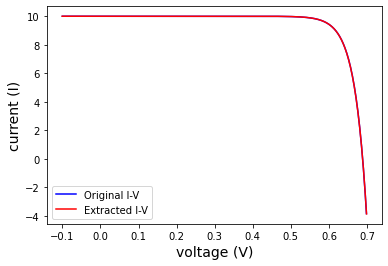

In [7]:
Rs=0
Rp=1e5
IV_curve = model_IV(Isc, I0, n, Rs, Rp, temperature)
Voc = get_Voc(IV_curve)

Isc_extr, I0_extr, n_extr, Rs_extr, Rp_extr = get_IV_params(IV_curve, temperature)

IV_curve_extracted = model_IV(Isc_extr, I0_extr, n_extr, Rs_extr, Rp_extr, temperature)
Voc_extr = get_Voc(IV_curve_extracted)

# Print the results and errors
print("Rp = " + f"{Rp_extr:.3f}")
print("Error Rp = " + f"{100*(Rp_extr-Rp)/Rp:.3f}" + " %")
print("Rs = " + f"{Rs_extr:.3f}")
#print("Error Rs = " + f"{100*(Rs_extr-Rs)/Rs:.3f}" + " %")
print("I0 = " + f"{I0_extr:.3}") 
print("Error I0 = " + f"{100*(I0_extr-I0)/I0:.3f}" + " %")
print("n = " + f"{n_extr:.3f}")
print("Error n = " + f"{100*(n_extr-n)/n:.3f}" + " %")
print("Isc = " + f"{Isc_extr:.3f}")
print("Error Isc = " + f"{100*(Isc_extr-Isc)/Isc:.3f}" + " %")
print("Voc = " + f"{Voc_extr:.3f}")
print("Error Voc = " + f"{100*(Voc_extr-Voc)/Voc:.3f}" + " %")

# Plot the I-V curves
plt.plot(IV_curve[:,0], IV_curve[:,1], color='b', label="Original I-V")
plt.plot(IV_curve_extracted[:,0], IV_curve_extracted[:,1], color='r', label = "Extracted I-V")
plt.xlabel('voltage (V)', size=14)
plt.ylabel('current (I)', size=14)
plt.legend()
plt.show()

As you can see, the I-V curve parameters extraction method is very accurate. <br>
Note that the error of I $_0$ seems high, but remember that its influence on the V $_{oc}$ is logarithmic. See how the error in V $_{oc}$ is negligible. <br>
The original I-V curve and the I-V curve constructed with the extracted parameters are virtually identical. <br>
<br>
However, the extraction method is not accurate for high values of Rs and/or Rp. <br>
Let´s  see how the method works for significant Rs and Rp values 

Rp = 0.413
Error Rp = 3.929 %
Rs = 0.015
Error Rs = -2.618 %
I0 = 4.51e-09
Error I0 = 125.544 %
n = 1.248
Error n = 4.000 %
Isc = 9.622
Error Isc = -3.781 %


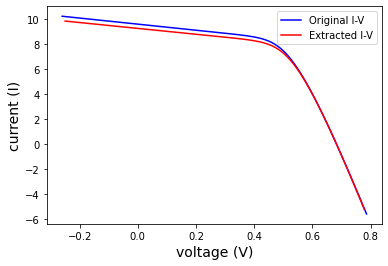

In [8]:
# We choose Rs and Rp values
Rs=0.0156
Rp=0.397

IV_curve = model_IV(Isc, I0, n, Rs, Rp, temperature)

Isc_extr, I0_extr, n_extr, Rs_extr, Rp_extr = get_IV_params(IV_curve, temperature)

IV_curve_extracted = model_IV(Isc_extr, I0_extr, n_extr, Rs_extr, Rp_extr, temperature)

# Print the results and errors
print("Rp = " + f"{Rp_extr:.3f}")
print("Error Rp = " + f"{100*(Rp_extr-Rp)/Rp:.3f}" + " %")
print("Rs = " + f"{Rs_extr:.3f}")
print("Error Rs = " + f"{100*(Rs_extr-Rs)/Rs:.3f}" + " %")
print("I0 = " + f"{I0_extr:.3}") 
print("Error I0 = " + f"{100*(I0_extr-I0)/I0:.3f}" + " %")
print("n = " + f"{n_extr:.3f}")
print("Error n = " + f"{100*(n_extr-n)/n:.3f}" + " %")
print("Isc = " + f"{Isc_extr:.3f}")
print("Error Isc = " + f"{100*(Isc_extr-Isc)/Isc:.3f}" + " %")

# Plot the I-V curves
plt.plot(IV_curve[:,0], IV_curve[:,1], color='b', label="Original I-V")
plt.plot(IV_curve_extracted[:,0], IV_curve_extracted[:,1], color='r', label = "Extracted I-V")
plt.xlabel('voltage (V)', size=14)
plt.ylabel('current (I)', size=14)
plt.legend()
plt.show()

You can see how the Pmax error increases when the effect of Rs and Rp increases. <br>